# Make Figure 5A: PTEN Mutation Frequency 

This notebook creates a bar chart that shows the frequency of different PTEN mutations found across 9 cancers.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import cptac
import cptac.utils as u
import plot_utils as p

In [2]:
print('cptac version:', cptac.version())

cptac version: 0.9.1


In [3]:
import warnings
warnings.filterwarnings('ignore')

# Step 1: Create df with Mutation Types

For each cancer type, create a df that has the mutation type for each sample.

First, load in the cancer data sets from cptac.

In [4]:
en = cptac.Endometrial()
hn = cptac.Hnscc()
l = cptac.Luad()
ls = cptac.Lscc()
o = cptac.Ovarian()
c = cptac.Ccrcc()
col = cptac.Colon()
g = cptac.Gbm()
b = cptac.Brca()

Next, call get_geneotype_all_vars for each cancer type. This returns a df with columns for Mutation (type of mutation), Location (location of the mutation), and Mutation_Status (wildtype, single, or multiple mutations).  For samples with multiple mutations, a single mutation was reported based on the following priority: deletion, truncation, missense, inframe, amplification, and wildtype. 

In [5]:
gene = "PTEN"

In [6]:
endo = en.get_genotype_all_vars(gene)
gbm = g.get_genotype_all_vars(gene)
hnscc = hn.get_genotype_all_vars(gene)
ovar = o.get_genotype_all_vars(gene)
cc = c.get_genotype_all_vars(gene)
colon = col.get_genotype_all_vars(gene)
ld = l.get_genotype_all_vars(gene)
lscc = ls.get_genotype_all_vars(gene)
brca = b.get_genotype_all_vars(gene)

In [7]:
# example
endo.head()

Name,Mutation,Location,Mutation_Status
Patient_ID,,,
C3L-00006,Nonsense_Mutation,p.R233*,Multiple_mutation
C3L-00008,Missense_Mutation,p.G127R,Single_mutation
C3L-00032,Nonsense_Mutation,p.W111*,Single_mutation
C3L-00090,Missense_Mutation,p.R130G,Multiple_mutation
C3L-00098,Wildtype_Tumor,No_mutation,Wildtype_Tumor


# Step 2: Match Mutation Labels

Mutations in the Colon dataset were named differently. We changed these names to match the other cancers. Nonframeshift insertion was changed to match In_Frame_Ins. Frameshift deletion was changed to match Frame_Shift_Del. Nonsynonymous snv represents a missense mutation in this case. 

In [8]:
colon["Mutation"] = colon['Mutation'].replace(['nonsynonymous SNV'], 'Missense')
colon["Mutation"] = colon['Mutation'].replace(['nonframeshift insertion'], 'In_Frame_Ins')
colon["Mutation"] = colon['Mutation'].replace(['frameshift deletion'], 'Frame_Shift_Del')

colon.Mutation.value_counts()

Wildtype_Tumor     76
Deletion           25
Missense            3
Amplification       1
Frame_Shift_Del     1
Name: Mutation, dtype: int64

We simplified labels for the final figure. We grouped mutations together to create the Indel and Truncation categories. Indel includes: In_Frame_Ins and In_Frame_Del. Truncation includes: Nonsense_Mutation, Frame_Shift_Del, and Frame_Shift_Ins.

In [9]:
# Simplify mutation names, create truncation and indel groups
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc, cc]
for df in dfs:
    df['Mutation'].where(df['Mutation'] != 'Missense_Mutation', 'Missense', inplace = True) # replace when false
    df['Mutation'].where(df['Mutation'] != 'Wildtype_Tumor', 'Wildtype', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'In_Frame_Del', 'Indel', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'In_Frame_Ins', 'Indel', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Nonsense_Mutation', 'Truncation', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Frame_Shift_Del', 'Truncation', inplace = True)
    df["Mutation"].where(df['Mutation'] != 'Frame_Shift_Ins', 'Truncation', inplace = True)

The get_genotype_all_var function created the No_Mutation label when no somatic mutations were found for PTEN in the Luad dataset. This is the same as Wildtype_Tumor. 

In [10]:
ld["Mutation"] = ld['Mutation'].replace(['No_Mutation'], 'Wildtype')

# Step 3: Create Figure

Create a list of the mutation dataframes. Create a list of cancer names for the figure legend. Call the plot_mutations function.

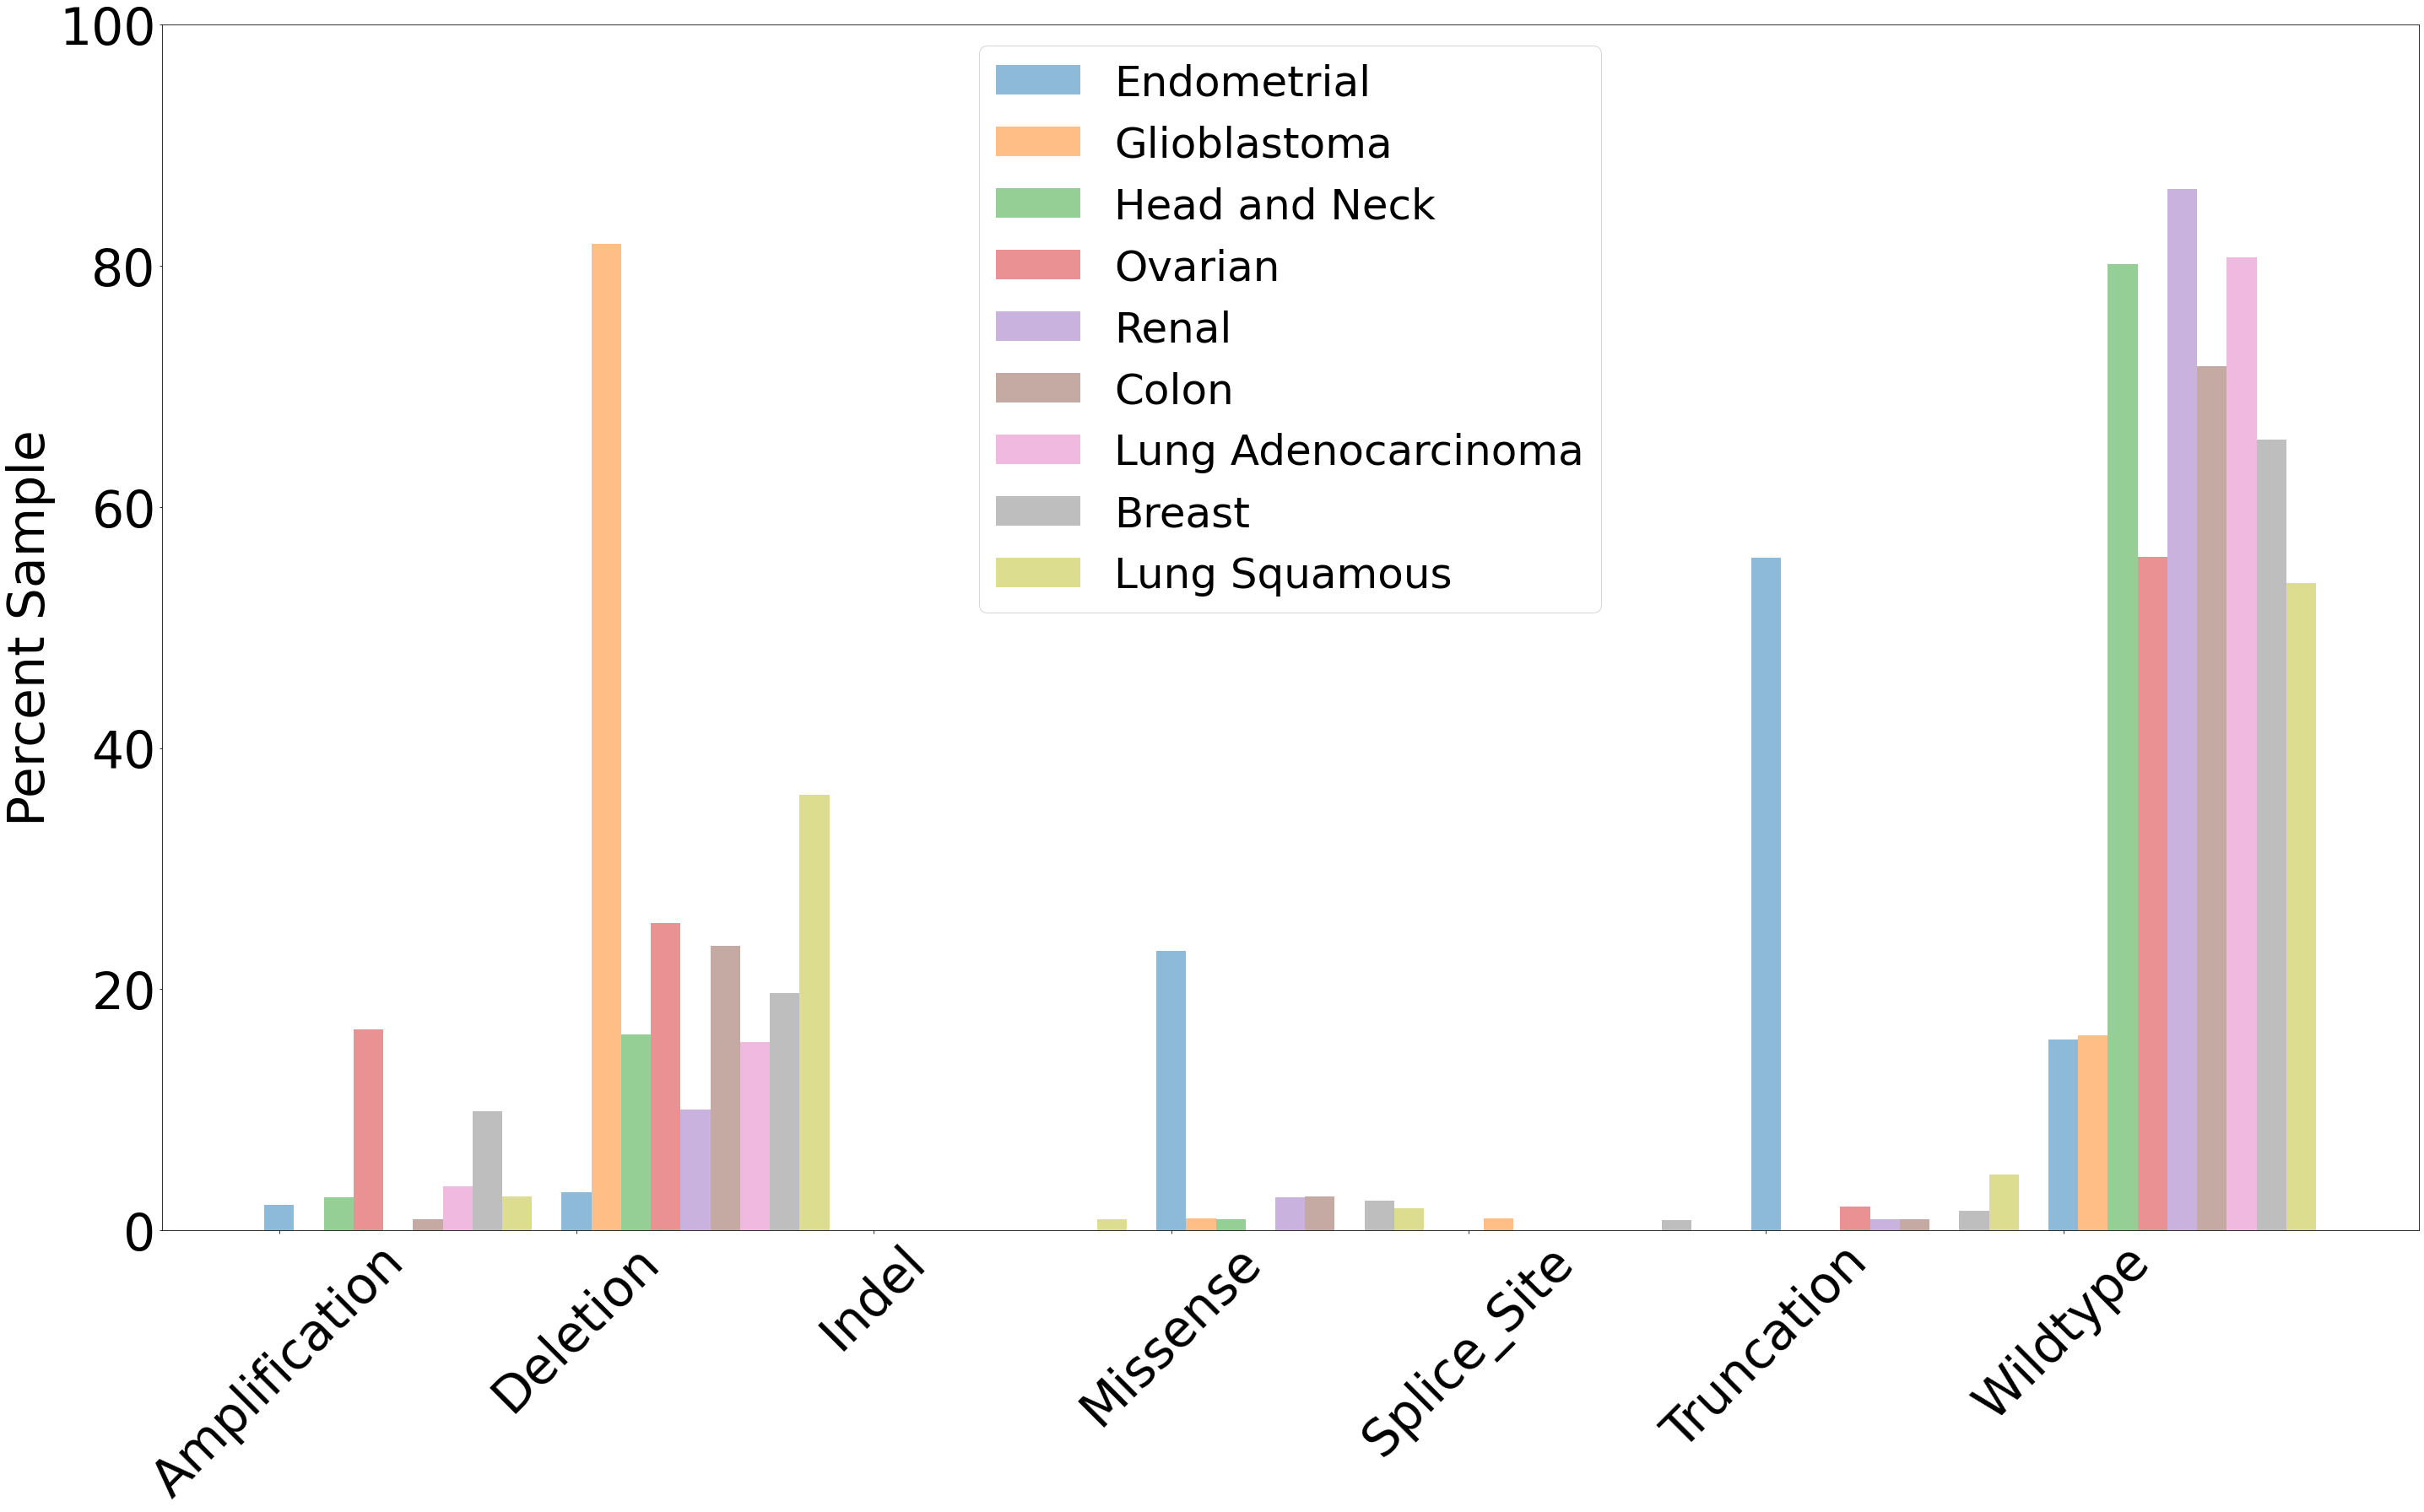

In [14]:
dfs = [endo, gbm, hnscc, ovar, cc, colon, ld, brca, lscc]  
names = ['Endometrial', 'Glioblastoma', 'Head and Neck', 'Ovarian', 'Renal', 'Colon', 'Lung Adenocarcinoma', 
         'Breast', 'Lung Squamous']
         
p.figure1_plot_mutations(dfs, names, save_to_path = "Fig_5A_flagship.png")

# Calculate percentage of PTEN deletion in cancers

The manuscript mentions the rounded percentages of PTEN deletions for the 7 cancers with frequent deletions.

In [12]:
cancer_dfs = {'GBM':gbm, 'LSCC':lscc, 'OV':ovar, 'CO':colon, 'BR':brca, 
              'HNSCC':hnscc, 'LUAD':ld, 'ccRCC':cc, 'EC':endo}

for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    cnv_del = vc.Deletion
    print(cancer)
    print('total_tumor_samples:',total)
    print(cnv_del,'/',total,'* 100 =', round(cnv_del/total * 100),'\n')

GBM
total_tumor_samples: 99
81 / 99 * 100 = 82 

LSCC
total_tumor_samples: 108
39 / 108 * 100 = 36 

OV
total_tumor_samples: 102
26 / 102 * 100 = 25 

CO
total_tumor_samples: 106
25 / 106 * 100 = 24 

BR
total_tumor_samples: 122
24 / 122 * 100 = 20 

HNSCC
total_tumor_samples: 111
18 / 111 * 100 = 16 

LUAD
total_tumor_samples: 109
17 / 109 * 100 = 16 

ccRCC
total_tumor_samples: 110
11 / 110 * 100 = 10 

EC
total_tumor_samples: 95
3 / 95 * 100 = 3 



# Calculate percentage of PTEN truncation in tumors

The manuscript mentions the rounded percentage of PTEN truncation mutations for Endometrial. 

In [13]:
cancer_dfs = {'EC':endo}
for cancer in cancer_dfs:
    df = cancer_dfs[cancer]
    vc = df.Mutation.value_counts()
    total = len(df)
    trunc = vc.Truncation
    print(cancer)
    print('total_tumor_samples:',total)
    print(trunc,'/',total,'=', round(trunc/total * 100),'\n')

EC
total_tumor_samples: 95
53 / 95 = 56 

